Vehicle Detection

[GTI* dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip)

In [3]:
import cv2
import numpy as np
import moviepy
import glob
import time
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
# Define a function to compute binned color features - optional
def bin_spatial(img, size=(32, 32)):
    return cv2.resize(img, size).ravel() 

# TODO: optional - test if it helps with classification accuracy
# Define a function to compute color histogram features - optional
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# TODO: refactor to have an Image class with methods 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                   visualise=vis, feature_vector=feature_vec)
    return features
        
def extract_features(imgs, cspace='YCrCb', orient=8, 
                     pix_per_cell=8, cell_per_block=1, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64,64))
        if cspace is not 'RGB':
            feature_image = cv2.cvtColor(img, getattr(cv2, "COLOR_RGB2{}".format(cspace)))
        else:
            feature_image = np.copy(img)      
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.hstack(
            (hog_features,
            color_hist(img),
            bin_spatial(img))
        ))
    # Return list of feature vectors
    return features

In [5]:
# read in test and training data
car_paths = glob.glob('vehicles/**/*.png')
not_car_paths = glob.glob('non-vehicles/**/*.png')

try:
    svc = pickle.load(open('svc_ycrcb.pickle', 'rb'))
    X_scaler = pickle.load(open('x_scaler_ycrcb.pickle', 'rb'))
    print('Loaded svc and X_scaler from pickles')
except FileNotFoundError:
    print('Training svc...')
    t1=time.time()
    x_cars = extract_features(car_paths, hog_channel='ALL', cspace='YCrCb')
    x_not_cars = extract_features(not_car_paths, hog_channel='ALL', cspace='YCrCb')
    t2=time.time()
    print(round(t2-t1, 2), 'Seconds to extract HOG features')

    X = np.vstack((x_cars, x_not_cars)).astype(np.float64)                        
    y = np.hstack((np.ones(len(x_cars)), np.zeros(len(x_not_cars))))

    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    # train naive bayes and svm from sklearn
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    svc.fit(X_train, y_train)

    t3=time.time()
    print(round(t3-t2, 2), 'Seconds to train SVC')
    print(round(svc.score(X_test, y_test), 4))

Loaded svc and X_scaler from pickles


In [6]:
pickle.dump(svc, open('svc_ycrcb.pickle', 'wb'))
pickle.dump(X_scaler, open('x_scaler_ycrcb.pickle', 'wb'))

In [7]:
# impl sliding windows
def find_cars(img, svc, X_scaler, window_size=64, ystart=400, ystop=656, scale=1.5, orient=8, pix_per_cell=8, cell_per_block=1, spatial_size=(32,32), hist_bins=32):
    bbox_list = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.concatenate((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
    
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg)
            combined = np.hstack((hog_features, hist_features, spatial_features)).reshape(1, -1)
            test_features = X_scaler.transform(combined)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return bbox_list

In [18]:
# impl video pipeline
# create heatmaps to show a single bbox per match
from collections import deque
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 5)
    # Return the image
    return img

def add_heat(bbox_list, heatmap):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def heatmap(img, bbox_list, thresh=1):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(bbox_list, heat)
    heat = apply_threshold(heat, thresh)
    return np.clip(heat, 0, 255)

class Processor:
    def __init__(self):
            self.heat_hist = deque(maxlen=4)
        
    def frame(self, img):
        pred_bbox = []
        ret = find_cars(img, svc, X_scaler, ystart=300, ystop=550, scale=1)
#         if len(ret) > 0:
#             pred_bbox.append(ret)
#         ret = find_cars(img, svc, X_scaler, ystart=300, ystop=600, scale=2.4)
        if len(ret) > 0:
            pred_bbox.append(ret)
        ret = find_cars(img, svc, X_scaler, ystart=350, ystop=700, scale=1.5)
        if len(ret) > 0:
            pred_bbox.append(ret)
        
        if len(pred_bbox) > 0:
            pred_bbox = np.concatenate(pred_bbox)
            # compute single frame heatmap
            heatmap_single = heatmap(img, pred_bbox, 5)
            self.heat_hist.append(heatmap_single)
        
        if len(self.heat_hist) is 0:
            return img
        
        # average heatmaps
        heat_sum = np.mean(self.heat_hist, 0)
        labels = label(apply_threshold(heat_sum, 6))
        return draw_labeled_bboxes(img, labels)

In [20]:
from moviepy.editor import VideoFileClip

p = Processor()
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(20,21)
clip = clip1.fl_image(p.frame)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 96%|█████████▌| 25/26 [01:51<00:04,  4.83s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 46s, sys: 1.91 s, total: 1min 48s
Wall time: 1min 53s


In [21]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

/usr/local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


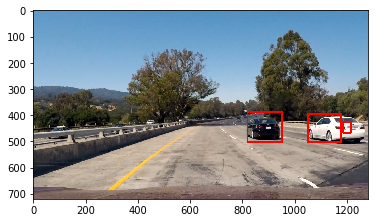

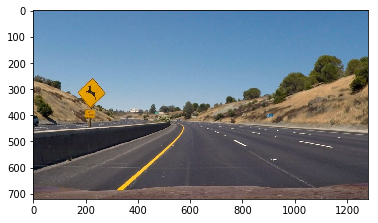

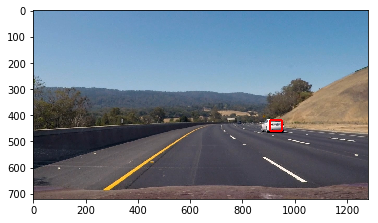

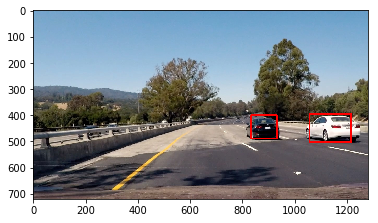

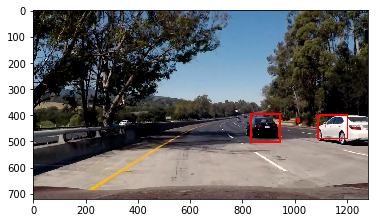

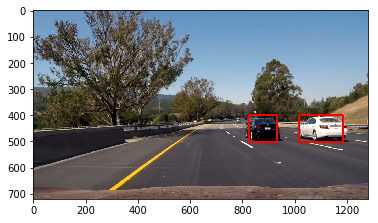

In [19]:
# save output images
paths = glob.glob('test_images/*')
for path in paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(Processor().frame(img))
    plt.show()